# Intro to using vaex with Gaia data

Although we recommend the [Full vaex tutorial](https://vaex.io/docs/tutorial.html), this notebook will give you a quick overview of how to use Vaex with the Gaia EDR3 data.

## Access to the Gaia Data

Although you can download/convert the Gaia data yourself, using Vaex, we can also access it remotely. Using Vaex' remote dataframe, we will only download the aggregated data, and never have to download the 1 Terabyte of data.

In [ ]:
import vaex
df = vaex.open(f'ws://dataframe-dev.vaex.io/gaia-edr3-x-ps1')

## Inspecting the data
The `df` object, is a vaex dataframe, an object very similar to the popular [Pandas](https://pandas.pydata.org/) library. The [tutorial](https://vaex.io/docs/tutorial.html) or [API documentation](https://vaex.io/docs/api.html) can be useful, but we will go through a few of these steps in this notebook as well.

A dataframe (in this case a remote dataframe, or remote dataset holding the Gaia dataset), can be printed out in the notebook to get an overview of the tabular data, its rows and columns.

In [ ]:
df

In [ ]:
len(df), len(df.get_column_names())

This shows that we have a remote dataset with ~1 billion rows and 200 columns (i.e 1 terrabytes of data, the fully cross matched Gaia dataset!) at our fingertips.

A column, can be be printed out (similar to pandas), using the dot notation `df.<columnname>`, or dictonary like access `df['<columnname>']`

In [ ]:
df.parallax

In this case, `df.parallax` is an expression that refers directly to the column with the same name. It is of float64 type, and the first 5 and last 5 rows will be printed. Thus only 10 floating point values are being transferred from the remote machine, to where this notebook runs.

## Calculations

Often the columns as given are not sufficient for the science we want to do, and we need to do custom calculations, such as converting parallax to distance.

In [ ]:
1/df.parallax

Vaex expressions can be used as regular numpy arrays, but they will not be evaluated eagerly, i.e. only the values that are needed (10 in this case) will be calculated. In this case, the expression `'1/distance'` will be send to the remote machine, where 10 distance values will be calculated, and send back.

## Virtual/synthetic columns
Instead of having to work with the colums that are given to us, we can create virtual (sometimes called synthetic) columns, using `df['<columnname>'] = <expression>`:

In [ ]:
df['distance'] = 1/df.parallax
df['G'] = df.phot_g_mean_mag  # a simple alias for the G magnitude

This makes it easier to work with the dataframe, that makes no distiction between real or virtual/synthetic columns. Note that nowhere does this virtual column takes up any significant memory. If we eagerly evaluated this column, it would take up ~8 gigabyte (GB) of memory, and would require us to download 8GB of data each time.

## Statistical calculations
Vaex has a [list of statistics](https://docs.vaex.io/en/latest/api.html#statistics) it can calculate on expressions. 

In [ ]:
Gmin, Gmax = df.minmax(df.G)
Gmin, Gmax

In [ ]:
df.count(df.G)

These statistical functions also take a `binby` argument (an expression or list of expressions) to calculate n-dimensional histograms, or other statics on a user defined regular grid.

In [ ]:
import numpy as np
counts_per_G_magnitude_bin = df.count(binby=df.G, limits=[Gmin, Gmax], shape=100)
counts_per_G_magnitude_bin

In [ ]:
import matplotlib.pylab as plt

Gdelta = (Gmax - Gmin)/100
centers_G_magnitude_bins = np.linspace(Gmin + Gdelta/2, Gmax+Gdelta/2, 100, endpoint=False)

plt.plot(centers_G_magnitude_bins, counts_per_G_magnitude_bin)
plt.title('G magnitude histogram')
plt.xlabel('G magnitude')
plt.ylabel('counts');

Since this is quite common, [vaex has a builtin method to do this](https://docs.vaex.io/en/latest/api.html#vaex.dataframe.DataFrame.plot1d)

In [ ]:
df.viz.histogram(df.G, limits=[Gmin, Gmax])

## Going two dimensional
If we pass binby, limits and shape a list of arguments, we can make higher dimensional histograms.

In [ ]:
limits_ra = [0, 360]
limits_dec = [-90, 90]
counts_per_sky_element = df.count(binby=[df.ra, df.dec], limits=[limits_ra, limits_dec], shape=[400,200], progress=True)
counts_per_sky_element

Which we can visualize using matplotlib's imshow.

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(np.log10(counts_per_sky_element).T, origin='lower')

Again, [vaex has a method to do this common operation](https://docs.vaex.io/en/latest/api.html#vaex.dataframe.DataFrame.plot):

In [ ]:
df.viz.heatmap(df.ra, df.dec, limits=[limits_ra, limits_dec], f='log10', colormap='viridis', figsize=(10,5))

## Other statistics
Instead of using count, we can also calculate the mean in each bin, using the [df.mean](https://docs.vaex.io/en/latest/api.html#vaex.dataframe.DataFrame.mean) method.

In [ ]:
mean_G_magntiude_per_sky_element = df.mean(df.G, binby=[df.ra, df.dec], limits=[limits_ra, limits_dec], shape=[400,200])
plt.figure(figsize=(10,5))
plt.imshow(mean_G_magntiude_per_sky_element.T, origin='lower')

In [ ]:
# or using df.viz
df.viz.heatmap(df.ra, df.dec, limits=[limits_ra, limits_dec], colormap='viridis', figsize=(10,5), what=vaex.stat.mean(df.G))

In [ ]:
## Making a histogram

In [ ]:
df.viz.histogram(df.distance, limits=[0, 20])

In [ ]:
# A nicer alias for the Bp color
df['Bp'] = df.phot_bp_mean_mag
# Note that here we keep the original expression around (not add a virtual expression)
# which will automatically generate nicer labels when plotting
color = df.Bp - df.G
# For the absolute magnitude we don't want to see the whole expression
# so we create a virtual columns
df['M_G'] = df.phot_g_mean_mag - 5 * np.log10(df.distance) - 10

In [ ]:
df.viz.heatmap(color, df.M_G, limits=[[-2, 4], [20, -7]], f='log')

# Filtering and selections data
We have seen we can add virtual columns, which we can use later on for statistical calculations, which can be used for visualizations.

We have used all the data up till now. Using filtering and selections, we can work on subsets of the data instead.

Filtering and selections are quite similar, the difference is in when you use it.

## Filtering

Using `df_filtered = df[<boolean expression>]` we can make a new dataframe, which will only use the rows matching the boolean expression. A common pattern is to reassign to `df`, in you are certain you don't need the unfiltered dataframe.

In [ ]:
df = df[df.distance > 0]

In [ ]:
df

Internally, vaex will remember the filter expression, and will send that to the server. At no moment will there by any copy of the data (remember 1 terabyte). 

## Selections
In the case of the distance filter, we know pretty well that we don't want any negative distance. In many cases you don't know for sure, and you want to explore a bit what are the best way to filter your dataframe.

All the statistical methods, and the visualization methods take a `selection=<boolean expression>` argument, or even a list of selections `selection=[<boolean expression>, ...]`.

In [ ]:
print(df.count(selection=str(df.parallax/df.parallax_error > 3))/1e6, 'million stars')

### Named selections
If this selection is going to be used a lot, it is also possible to add a so called named selection (where the default name is `default`). The advantage of named selections is that vaex can internally do some caching, so in general it will be faster.

In [ ]:
df.select(
    (df.parallax/df.parallax_error > 10) &\
    (df.distance < 1) &\
    (df.phot_g_mean_flux_over_error > 2000)
    , name='default')

In [ ]:
print(df.count(selection='default')/1e6, 'million stars')

In [ ]:
df.plot(color, df.M_G, limits=[[-0.5, 1.5], [22, -10]], f='log', selection='default')

In [ ]:
df[(df.parallax_over_error>5) & (df.distance < 10)].viz.heatmap(color, df.M_G, limits=[[-2, 4], [20, -7]], f='log')

# UDFs: User defined functions

Since vaex supports many numpy functions, we can do many transformations of the data, for instance a transformation of spherical to cartesian coordinates. Vaex comes with many transformation already included, for instance:

In [ ]:
# E.g. we don't need to do this:
# df_extra = df.copy()
# df_extra['x'] = np.cos(df.l) * np.cos(df.b) * df.distance
# df_extra['y'] = np.sin(df.l) * np.cos(df.b) * df.distance
# df_extra['z'] = np.sin(df.b) * df.distance

# this is much shorter and less error prone
df_extra = df.geo.spherical2cartesian(df.l, df.b, df.distance)
df_extra.plot('x', 'z', limits=[-9, 9], f='log')

In [ ]:
df_extra.plot('y', 'z', limits=[-20, 20], f='log')

However, it can happpen that a function cannot simply be expressed using basic numpy function (for instance if statements). In this case it is possible to add a new function to vaex.

In [ ]:
# if we pass vaex expressions to this function, it will fail (since astropy expects real numpy arrays somewhere)
def sky_separation(ra, dec, ra0, dec0, frame='icrs'):
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    c1 = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame=frame)
    c2 = SkyCoord(ra=ra0*u.degree, dec=dec0*u.degree, frame=frame)
    return np.array(c1.separation(c2))
# However, we can add a new function to vaex
sky_separation = df.add_function('sky_separation', sky_separation)

In [ ]:
sky_separation(df.ra, df.dec, 0, 0)

In [ ]:
df['seperation_center'] = sky_separation(df.ra, df.dec, 0, 0)

In [ ]:
df.plot(df.ra, df.dec, what=vaex.stat.mean(df.seperation_center),  limits=[limits_ra, limits_dec])

Vaex will serialize (pickle) the function, send it to the remote machine. On the remote machine, the function is being applied on a chunk by chunk basis (with real numpy arrays). Note that this allows for arbitrary code execution, which is a security risk, and therefore requires the secret token (token_trusted) when connecting. Only trusted users (you) will be given this token, please use this feature responsibly.

# Field of streams


In [ ]:
import vaex
import numpy as np
import warnings
warnings.simplefilter(action="ignore")

df = vaex.open(f'ws://dataframe-dev.vaex.io/gaia-edr3-x-ps1')

In [ ]:
g = df.phot_g_mean_mag
bp = df.phot_bp_mean_mag
rp = df.phot_rp_mean_mag

filter = g < 20.5
filter &= df.parallax < 2*df.parallax_error
filter &= np.sqrt(df.pmra**2 + df.pmdec**2) < 4
filter &= (bp - rp) > 0.9
filter &= g < 20
dff = df[filter.jit_numba()]
# dff = df

dff['aux'] = g + 20*(bp - rp - 1)
aux_ranges = [[18.5, 20],[17, 18.5],[15.5, 17]]

limits_ra = [0, 360]
limits_dec = [-90, 90]
limits = [limits_ra, limits_dec]

In [ ]:
# aux_range = ranges[0]
dff.viz.heatmap(dff.ra, dff.dec,
    selection=[(dff.aux >= aux_range[0]).jit_numba() & (dff.aux < aux_range[1]) for aux_range in aux_ranges],
    visual=dict(column='selection'),
    limits=limits,
    f="log1p",
    figsize=(20,5))

## RGB Image

In [ ]:
%%time
grid_rgb3d = dff.count(
    binby=['ra', 'dec'],
    limits=limits,
    selection=[str((dff.aux >= aux_range[0]).jit_numba() & (dff.aux < aux_range[1])) for aux_range in aux_ranges]
)

In [ ]:
grid_rgb3d.shape

In [ ]:
import scipy.stats
import matplotlib.pylab as plt

def mapper(x):
    p1, p2 = [scipy.stats.scoreatpercentile(x, p) for p in [1,65]]
    return (np.clip(x, p1, p2)*1. - p1) / (p2 - p1)

plt.figure(figsize=(20,10))
plt.imshow(np.array([mapper(k) for k in grid_rgb3d]).T, origin="lower")

TODO: Compare to SQL
 Maybe do count(..) WHERE <filter>

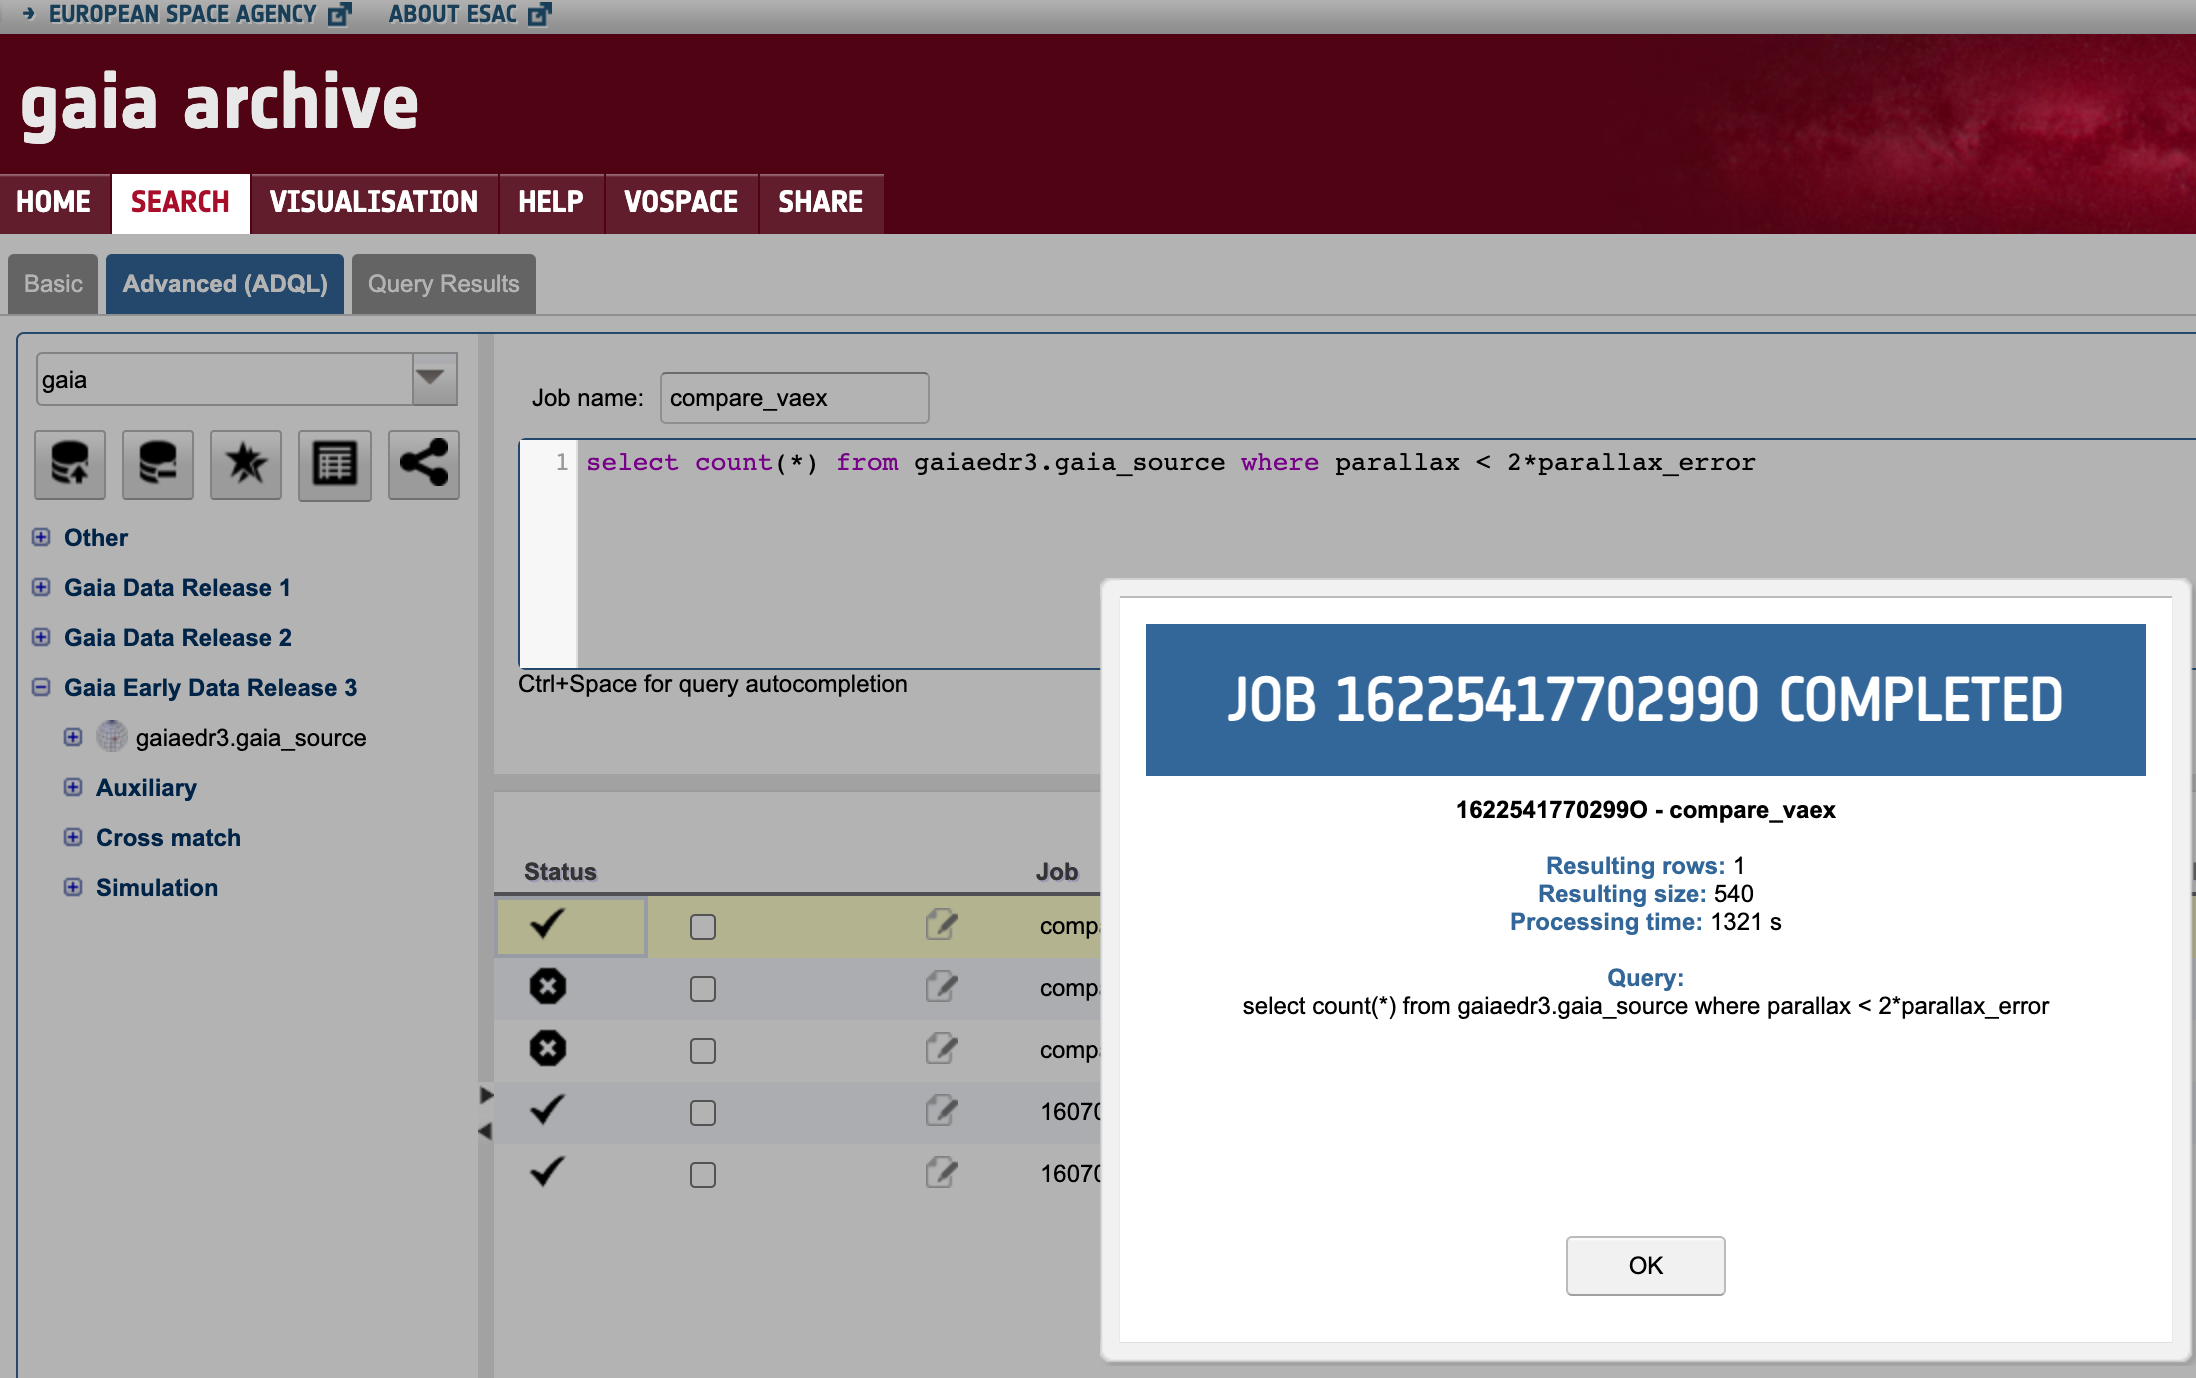

In [ ]:
print(f"speedup: > {1321/6}x")

# Next

 * Please go through the [tutorial](https://docs.vaex.io/en/latest/tutorial.html) to learn about:
   * Interactive visualization
   * Error/uncertainty propagation

* Or check out the voila notebooks for interactive dashboards

